# <font style="color: rgb(0,0,0);">Option B: </font> <font style="color: rgb(190,138,67);">Transport efficiency</font>

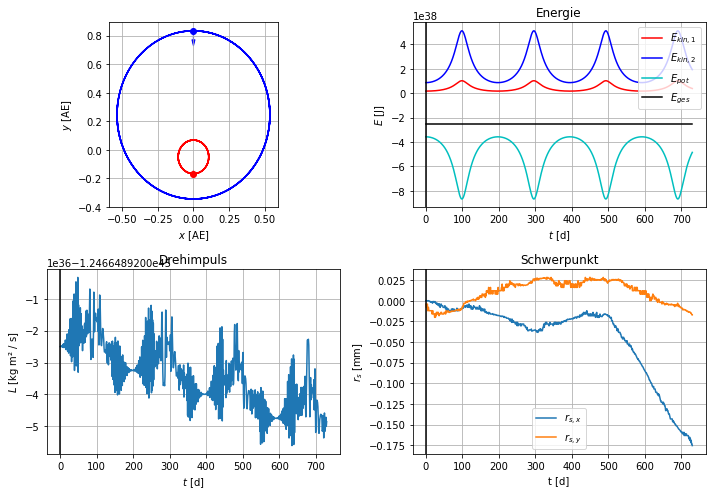

In [204]:
"""Simulation eines Doppelsternsystems im Schwerpunktssystem. """

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation
import scipy.integrate

# Konstanten 1 Tag [s] und 1 Jahr [s].
tag = 24 * 60 * 60
jahr = 365.25 * tag

# Eine Astronomische Einheit [m].
AE = 1.495978707e11

# Skalierungsfaktor für die Darstellung der Beschleunigung
# [AE / (m/s²)].
scal_a = 20

# Simulationszeitdauer T und dargestellte Schrittweite dt [s].
T = 2 * jahr
dt = 1 * tag

# Graviationskonstante [m³ / (kg * s²)].
G = 6.674e-11

# Massen der beiden Sterne [kg].
m1 = 2.0e30
m2 = 4.0e29

# Anfangspositionen der Körper [m].
r0_1 = AE * np.array([0.0, 0.0])
r0_2 = AE * np.array([0.0, 1.0])

# Anfangsgeschwindigkeiten der Sterne [m/s].
v0_1 = np.array([0.0, 0])
v0_2 = np.array([25e3, 0])

# Berechne die Schwerpunktsposition und -geschwindigkeit und
# ziehe diese von den Anfangsbedingungen ab.
rs0 = (m1 * r0_1 + m2 * r0_2) / (m1 + m2)
vs0 = (m1 * v0_1 + m2 * v0_2) / (m1 + m2)
r0_1 -= rs0
r0_2 -= rs0
v0_1 -= vs0
v0_2 -= vs0


def dgl(t, u):
    r1, r2, v1, v2 = np.split(u, 4)
    a1 = G * m2 / np.linalg.norm(r2 - r1)**3 * (r2 - r1)
    a2 = G * m1 / np.linalg.norm(r1 - r2)**3 * (r1 - r2)
    return np.concatenate([v1, v2, a1, a2])


# Lege den Zustandsvektor zum Zeitpunkt t=0 fest.
u0 = np.concatenate((r0_1, r0_2, v0_1, v0_2))

# Löse die Bewegungsgleichung bis zum Zeitpunkt T.
result = scipy.integrate.solve_ivp(dgl, [0, T], u0, rtol=1e-9,
                                   t_eval=np.arange(0, T, dt))
t = result.t
r1, r2, v1, v2 = np.split(result.y, 4)

# Berechne die verschiedenen Energiebeiträge.
E_kin1 = 1/2 * m1 * np.sum(v1 ** 2, axis=0)
E_kin2 = 1/2 * m2 * np.sum(v2 ** 2, axis=0)
E_pot = - G * m1 * m2 / np.linalg.norm(r1 - r2, axis=0)

# Berechne den Gesamtimpuls.
p = m1 * v1 + m2 * v2

# Berechne die Position des Schwerpunktes.
rs = (m1 * r1 + m2 * r2) / (m1 + m2)

# Berechne den Drehimpuls.
L = m1 * np.cross(r1, v1, axis=0) + m2 * np.cross(r2, v2, axis=0)

# Erzeuge eine Figure.
fig = plt.figure(figsize=(10, 7))
fig.set_tight_layout(True)

# Erzeuge eine Axes für die Bahnkurve der Sterne.
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel('$x$ [AE]')
ax1.set_ylabel('$y$ [AE]')
ax1.set_aspect('equal')
ax1.grid()

# Plotte die Bahnkurven der Sterne.
ax1.plot(r1[0] / AE, r1[1] / AE, '-r')
ax1.plot(r2[0] / AE, r2[1] / AE, '-b')

# Erzeuge eine Punktplot, für die Positionen der Himmelskörper.
stern1, = ax1.plot([0], [0], 'o', color='red')
stern2, = ax1.plot([0], [0], 'o', color='blue')

# Erzeuge zwei Pfeile für die Beschleunigungsvektoren.
style = mpl.patches.ArrowStyle.Simple(head_length=6,
                                      head_width=3)
arrow_a1 = mpl.patches.FancyArrowPatch((0, 0), (0, 0),
                                       color='red',
                                       arrowstyle=style)
arrow_a2 = mpl.patches.FancyArrowPatch((0, 0), (0, 0),
                                       color='blue',
                                       arrowstyle=style)

# Füge die Pfeil zur Axes hinzu.
ax1.add_artist(arrow_a1)
ax1.add_artist(arrow_a2)

# Erzeuge eine Axes und plotte die Energie.
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title('Energie')
ax2.set_xlabel('$t$ [d]')
ax2.set_ylabel('$E$ [J]')
ax2.grid()
ax2.plot(t / tag, E_kin1, '-r', label='$E_{kin,1}$')
ax2.plot(t / tag, E_kin2, '-b', label='$E_{kin,2}$')
ax2.plot(t / tag, E_pot, '-c', label='$E_{pot}$')
ax2.plot(t / tag, E_pot + E_kin1 + E_kin2,
         '-k', label='$E_{ges}$')
ax2.legend()

# Erzeuge eine Axes und plotte den Drehimpuls.
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title('Drehimpuls')
ax3.set_xlabel('$t$ [d]')
ax3.set_ylabel('$L$ [kg m² / s]')
ax3.grid()
ax3.plot(t / tag, L)

# Erzeuge eine Axes und plotte den Schwerpunkt.
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title('Schwerpunkt')
ax4.set_xlabel('t [d]')
ax4.set_ylabel('$r_s$ [mm]')
ax4.grid()
ax4.plot(t / tag, 1e3 * rs[0, :], label='$r_{s,x}$')
ax4.plot(t / tag, 1e3 * rs[1, :], label='$r_{s,y}$')
ax4.legend()

# Sorge dafür, dass die folgenden Linien nicht mehr die
# y-Skalierung verändern.
ax2.set_ylim(auto=False)
ax3.set_ylim(auto=False)
ax4.set_ylim(auto=False)

# Erzeuge drei schwarze Linien, die die aktuelle Zeit in den
# Plots für Energie, Impuls und Drehimpuls darstellen.
linie_t2, = ax2.plot(0, 0, '-k')
linie_t3, = ax3.plot(0, 0, '-k')
linie_t4, = ax4.plot(0, 0, '-k')


def update(n):
    # Aktualisiere die Positionen der Sterne.
    stern1.set_data(r1[:, n] / AE)
    stern2.set_data(r2[:, n] / AE)

    # Berechne die Momentanbeschleunigung und aktualisiere die
    # Vektorpfeile.

    v_1, v_2, a_1, a_2 = np.split(dgl(t[n], result.y[:, n]), 4)
    arrow_a1.set_positions(r1[:, n] / AE,
                           r1[:, n] / AE + scal_a * a_1)
    arrow_a2.set_positions(r2[:, n] / AE,
                           r2[:, n] / AE + scal_a * a_2)

    # Stelle die Zeit in den drei anderen Diagrammen dar.
    t_akt = t[n] / tag
    linie_t2.set_data([[t_akt, t_akt], ax2.get_ylim()])
    linie_t3.set_data([[t_akt, t_akt], ax3.get_ylim()])
    linie_t4.set_data([[t_akt, t_akt], ax4.get_ylim()])

    return (stern1, stern2, arrow_a1, arrow_a2,
            linie_t2, linie_t3, linie_t4)


# Erzeuge das Animationsobjekt und starte die Animation.
ani = mpl.animation.FuncAnimation(fig, update, interval=30,
                                  frames=t.size, blit=True)
fig.set_tight_layout(True)
plt.show()

> Apollo 11 https://www.hq.nasa.gov/alsj/nasa58040.pdf
<br>
> Apollo 17 https://history.nasa.gov/alsj/a17/A17_MissionReport.pdf

In [1]:
# imports
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import matplotlib.pyplot as plt


In [175]:
# set launch carrier properties
# EL3 - European Large Logistics Lander
mass_dry  = 1600 # kg
mass_full = 8500 # kg
mass_fuel = mass_full - mass_dry # kg
m_flow = 10 # [kg/s] massflow
I_sp = 453 # [s] specific impulse
g_0 = 9.80665 # [kg/s²] standard gravity
EEV = I_sp * g_0 # [m/s] effective exhaust velocity


r_moon = 1737400    # [m] volumetric mean radius of the moon
m_moon = 0.07346e24 # [kg] mass of the moon
G = 6.67430e-11 # Gravitational constant

def acc_grav_moon(r):
    radial = G * (m_moon/(r**2))
    return np.array([-radial,0], dtype=np.float64)

def acc_centrifugal(v_phi,r):
    radial = (v_phi**2)/(r)
    return np.array([radial,0], dtype=np.float64)

print('test acc_grav_moon(r) function:',acc_grav_moon(r_moon),'[m/s²]','vs. 1.622 [m/s²] expected on surface')

def acc_propulsion(m):
    F_thrust = m_flow * EEV
    return F_thrust / m
    
print('test acc_propulsion(m) function:',acc_propulsion(mass_full),'[m/s²]')


# acceleration direction from propulsion
#         0°
#         │                
# 270° ───┼─── 90°     reference angle from vertical axis, perpendicular to lunar surface
#         │
#        180°

def vec_from_angle(deg): # in [x,y] cartesian-coordinates
    rad = np.deg2rad(90-deg)

    x = np.sin(rad)
    y = np.cos(rad)
    vec = np.array([x,y], dtype=np.float64)
    
    
    # verify
    vector_1 = [1, 0]
    vector_2 = vec

    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    print(f'vector angle is {np.rad2deg(angle)}°')
    
    return vec

def plot_vector(vec):
    
    plt.figure(figsize=(3, 3), dpi=50)
    
    # reference vector
    xpoints = np.array([0, 0])
    ypoints = np.array([0, 1])
    plt.plot(xpoints, ypoints, '--', color = 'b')
    
    xpoints = np.array([0, vec[1]])
    ypoints = np.array([0, vec[0]])
    plt.plot(xpoints, ypoints, color = 'r')
    
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    
    plt.gca().set_aspect('equal', adjustable='box')
    
    #unit circle
    t = np.linspace(0,np.pi*2,100)
    plt.plot(np.cos(t), np.sin(t), linewidth=2)
    
    plt.axis('off')
    plt.show()

4442.41245 [m/s]
test acc_grav_moon(r) function: [-1.62426548  0.        ] [m/s²] vs. 1.622 [m/s²] expected on surface
test acc_propulsion(m) function: 5.226367588235294 [m/s²]



┌───────────┬─────────────────────────────────┐
│  Phase 1  │          Vertical rise          │
└───────────┴─────────────────────────────────┘
vector angle is 0.0°


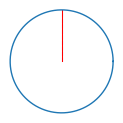


┌───────────┬─────────────────────────────────┐
│  Phase 2  │      first tilt, 38° burn       │
└───────────┴─────────────────────────────────┘
vector angle is 37.99999999999999°


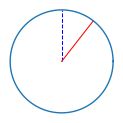


┌───────────┬─────────────────────────────────┐
│  Phase 3  │     second tilt, 52° burn       │
└───────────┴─────────────────────────────────┘
vector angle is 52.0°


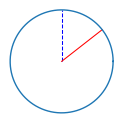


┌───────────┬─────────────────────────────────┐
│  Phase 4  │   orbit injection, 89.66° burn  │
└───────────┴─────────────────────────────────┘
vector angle is 79.66°


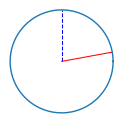


┌───────────┬─────────────────────────────────┐
│  Phase 5  │   orbit propagate, engine off   │
└───────────┴─────────────────────────────────┘


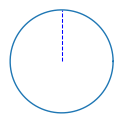


├───────────────── FINISHED ──────────────────┤

     time [s]     loc_r [m]   loc_phi [m]  mass [kg]   altitude [m]  velocity_r [m/s]  velocity_phi [m/s]  acceleration_r [m/s²]  acceleration_phi [m/s²]
0         0.0  1.737400e+06  0.000000e+00    8500.00       0.000000          0.000000        0.000000e+00               0.000000             0.000000e+00
1         1.0  1.737402e+06  1.595941e-16    8490.00       1.796671          3.601569        3.198905e-16               3.608255             3.203993e-16
2         2.0  1.737407e+06  6.395868e-16    8480.00       7.201589          7.212909        6.404785e-16               3.614436             3.207771e-16
3         3.0  1.737416e+06  1.440356e-15    8470.00      16.220939         10.830441        9.614447e-16               3.620638             3.211558e-16
4         4.0  1.737429e+06  2.562281e-15    8460.00      28.860921         14.454185        1.282790e-15               3.626861             3.215354e-16
...       ...           ..

In [202]:
# SIMULATION

# setup parameters
t_step = 0.001 # [s] time for one simulation step
t_step = np.array(t_step, dtype=np.float64) 
digit_precision = 3

time = np.array(0, dtype=np.float64)

# polar coordinates - 2D simulation - Circle

# Mass
m = mass_full  # [kg]

# location
loc_r   = r_moon  # [m]
loc_phi = 0       # [m]
loc = np.array([loc_r,loc_phi], dtype=np.float64)

# velocity
vel_r   = 0  # [m/s]
vel_phi = 0  # [m/s]
vel = np.array([vel_r,vel_phi], dtype=np.float64)

# acceleration
acc_r   = 0  # [m/s²]
acc_phi = 0  # [m/s²]
acc = np.array([acc_r,acc_phi], dtype=np.float64)

# engine toggle
engine_on = True


# pandas df for logging
df = pd.DataFrame(columns=['time [s]','loc_r [m]','loc_phi [m]', 'mass [kg]', 'altitude [m]','velocity_r [m/s]','velocity_phi [m/s]','acceleration_r [m/s²]','acceleration_phi [m/s²]'])
df.loc[0] = [time,loc[0],loc[1],m,loc[0]-r_moon,vel[0],vel[1],acc[0],acc[1]]

def log(x=1,full=False):
    if full:
        # full logging - WARNING : slow!
        df.loc[df.shape[0]] = [time,loc[0],loc[1],m,loc[0]-r_moon,vel[0],vel[1],acc[0],acc[1]]
    else:
        # logging results only every x seconds
        if (time*1000)%(x) == 0:
            df.loc[df.shape[0]] = [time,loc[0],loc[1],m,loc[0]-r_moon,vel[0],vel[1],acc[0],acc[1]]
            
def phys_sim_step():
    
    global time, loc, vel, acc, m
    
    # one sim step BEGIN
    ###############################
    new_loc_r = loc[] + ( vel * t_step)
    
    new_vel = vel + ( acc * t_step)
    new_acc = (dir_n * acc_propulsion(m)) + acc_grav_moon(loc[0]) + acc_centrifugal(vel[1],loc[0])
    
    if engine_on: new_mass = m - (m_flow * t_step)
    else: new_mass = m
    
    loc = new_loc
    vel = new_vel
    acc = new_acc
    m = new_mass
    time = np.around(time + t_step,digit_precision)

    ###############################
    # one sim step END
    

# Simulation execution



print('''
┌───────────┬─────────────────────────────────┐
│  Phase 1  │          Vertical rise          │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(0)
plot_vector(dir_n)

# stop condition: vertical velocity
# 50 [ft/s] = 15.25 [m/s]
while vel[0] < 15.25: 
    
    phys_sim_step()
    
    log(1000) # log every x [ms]
        

print('''
┌───────────┬─────────────────────────────────┐
│  Phase 2  │      first tilt, 38° burn       │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(38)
plot_vector(dir_n)

# stop condition: vertical velocity
# 70 [ft/s] = 21.34 [m/s]
while vel[0] < 21.34:
    
    phys_sim_step()
    
    log(1000) # log every x [ms]


print('''
┌───────────┬─────────────────────────────────┐
│  Phase 3  │     second tilt, 52° burn       │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(52)
plot_vector(dir_n)

# stop condition: vertical velocity
# 73 [ft/s] = 22.25 [m/s]
while vel[0] < 22.25:
    
    phys_sim_step()
    
    log(1000) # log every x [ms]

# Phase 4: Orbit injection
print('''
┌───────────┬─────────────────────────────────┐
│  Phase 4  │   orbit injection, 89.66° burn  │
└───────────┴─────────────────────────────────┘''')

dir_n = vec_from_angle(79.66)
plot_vector(dir_n)

while vel[1] < 1680:
    
    phys_sim_step()
    
    log(1000) # log every x [ms]

print('''
┌───────────┬─────────────────────────────────┐
│  Phase 5  │   orbit propagate, engine off   │
└───────────┴─────────────────────────────────┘''')

dir_n =  np.array([0,0], dtype=np.float64)
plot_vector(dir_n)
engine_on = False
while time < 5000:
    
    phys_sim_step()
    
    log(1000) # log every x [ms]

    
print('''
├───────────────── FINISHED ──────────────────┤
''')
print(df)



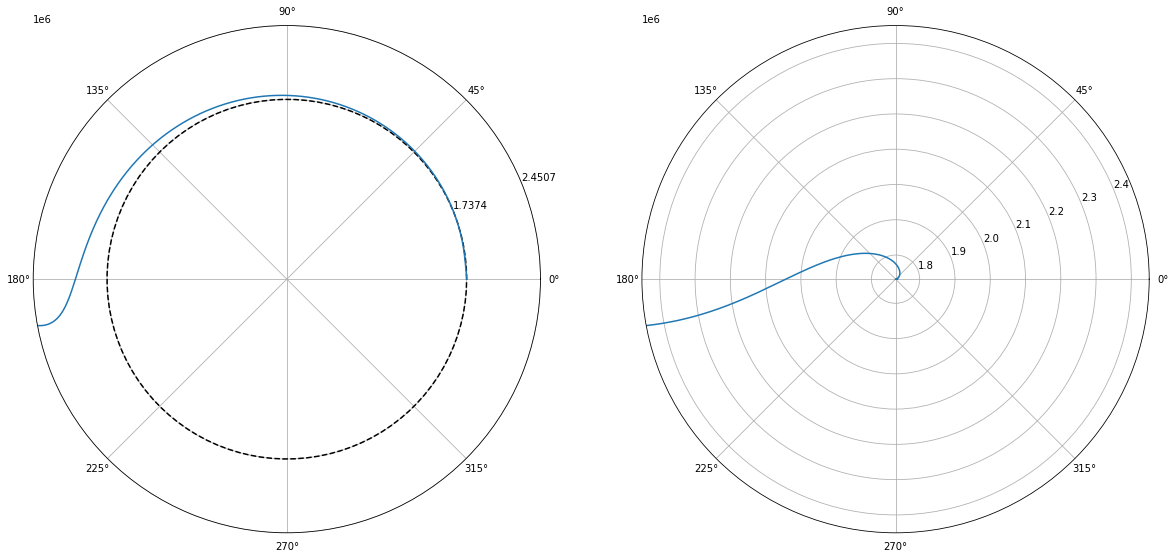

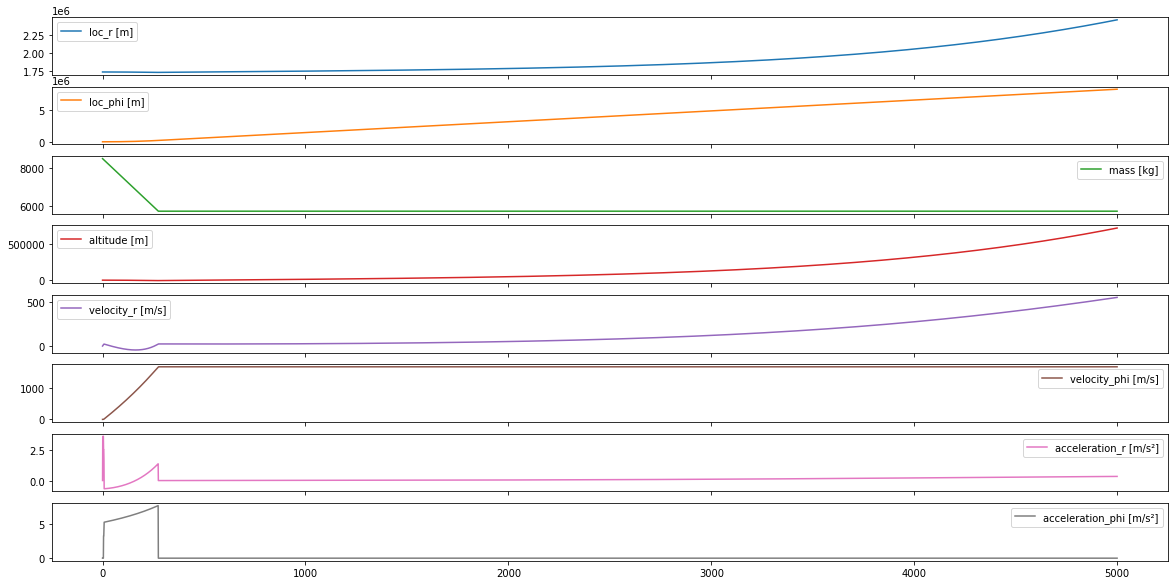

In [203]:
# plot path

# moon surface
plot_r_moon = np.array([r_moon]*100)
plot_phi_moon = np.linspace(0,2*np.pi,100)


# rocket location
r = df['loc_r [m]'].values
phi = df['loc_phi [m]'].values / df['loc_r [m]'].values
#print(np.around(phi,3))

fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': 'polar'},figsize=(20,10))

ax1.plot(plot_phi_moon, plot_r_moon, linestyle='dashed',color='black')
ax1.plot(phi, r)
ax1.set_rmax(max(r))
ax1.set_rmin(0)
ax1.set_rticks([r_moon,max(r)])  # Less radial ticks
#ax1.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax1.grid(True)

ax2.plot(phi, r)
ax2.set_rmax(max(r))
ax2.set_rmin(min(r))

plt.show()

# plot result properties graphs
df.plot(subplots=True,figsize=(20,10))
plt.show()

In [17]:
# pip install "C:\Program Files\AGI\STK 12\bin\AgPythonAPI\agi.stk12-12.2.0-py3-none-any.whl"
# run this notebook from STK's Python Scripting Interface

In [18]:
# STK library imports
from agi.stk12.stkdesktop import STKDesktop
from agi.stk12.stkobjects import *
from agi.stk12.stkutil import *
from agi.stk12.vgt import *
# if using astrogator uncomment the below
# from agi.stk12.stkobjects.astrogator
# if using aviator uncomment the below
# from agi.stk12.stkobjects.aviator

# Python helper library imports
import os
from tqdm.notebook import tqdm
from ipywidgets import *
import time
import numpy as np
import plotly.express as px
import xarray as xr

In [3]:
# helper functions

# model for launch segment

# plot xArray data

## Destination: Gateway (Near-Rectilinear Halo Orbit)
> open file "Gateway_PROP_Mass_Point.sc" in STK

### connect to STK session and grab elements

In [21]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('NRHO_Sat')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

agi.stk12.stkobjects.AgStkObjectRoot

In [5]:
#satellite  = AgSatellite(root.CurrentScenario.Children.New(AgESTKObjectType.eSatellite,"LeoSat"))
#place_start  = AgPlace(scenario.Children.New(AgESTKObjectType.ePlace,"Start"))

In [7]:
#def analyse(object):
#    print([method_name for method_name in dir(object)if callable(getattr(object, method_name))])
#print(satellite.Propagator.__dict__.keys())

# use dir() instead

In [8]:
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
#analyse(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0))
# Name
# FinalValue
# LastUpdate
#dir(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0))
# Name
# CurrentValue
# DesiredValue
# Difference
# Values


# pull data
#print(satellite.Propagator.MainSequence.Item(2).GetResultValue('Eccentricity'))

#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue
#satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Results.Item(0).Name

# set data
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).BurnoutVelocity._SetFixedVelocity(1)
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = 44
#satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0

In [10]:
#airtemps = xr.tutorial.open_dataset('air_temperature').air.isel(time=500)
#airtemps

In [15]:
#colorbar_title = results.attrs['var_desc'] + '<br>(%s)'%results.attrs['units']
#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
#fig.show()
#fig.write_image("images/fig1.pdf")
#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print()
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).Name)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000)
#print(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000)

#dir(satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0))

#print(satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status)

#dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
#dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
#dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
#dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
#dv2 = np.linalg.norm(dv2_vec)
#print(dv2)

### control STK and compute global result

In [16]:
####################################################################################
# WARNING !    this step takes approx. 4 hours to compute for 5 deg resolution     #
####################################################################################

# calculation steps in deg for geodetic location
resolution = 30

print('Result image resolution:',1+(360/resolution),'x',1+(180/resolution))
n_total = (1+(360/resolution))*(1+(180/resolution))
print('number of calculations:',n_total)

if n_total != int(n_total): print("WARNING: non matching map!")

Longitude = []
Latitude = []

for Lon in range(-180,181,resolution):
    Longitude.append(Lon)
for Lat in range(-90,91,resolution):
    Latitude.append(Lat)


Latitude = list(reversed(Latitude))

deltaV_Gateway = np.zeros((len(Latitude), len(Longitude)))
deltaV_Gateway[:] = np.nan

fuel_mass_Gateway = np.zeros((len(Latitude), len(Longitude)))
fuel_mass_Gateway[:] = np.nan

print()
print(len(Longitude),Longitude)
print()
print(len(Latitude),Latitude)

with tqdm(total=n_total) as pbar:
    for Lat_count, Lat in enumerate(Latitude):
        for Lon_count, Lon in enumerate(Longitude):
            #print("Lat:",Lat,"Lon:",Lon)
            place_start.Position.AssignGeodetic(Lat,Lon,0)
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Latitude = Lat
            satellite.Propagator.MainSequence.Item(0).Segments.Item(0).DisplaySystem.Longitude = Lon
            if Lon > -90 and Lon < 90:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = -180
            else:
                satellite.Propagator.MainSequence.Item(0).Segments.Item(0).Burnout.Azimuth = 0
                
            satellite.Propagator.RunMCS()
            check1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).Status
            check2 = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).Status
            if check1 == "Converged" and check2 == "Converged":
                
                # Launch: Burnout.FixedVelocity
                dv1 = satellite.Propagator.MainSequence.Item(0).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                # Maneuver: ImpulsiveMnvr.Pointing.Cartesian.X /Y /Z
                dv2_x = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(0).FinalValue*1000
                dv2_y = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(1).FinalValue*1000
                dv2_z = satellite.Propagator.MainSequence.Item(3).Profiles.Item(0).ControlParameters.Item(2).FinalValue*1000
                dv2_vec = np.array([dv2_x, dv2_y, dv2_z])
                dv2 = np.linalg.norm(dv2_vec)

                deltaV_Gateway[Lat_count][Lon_count] = dv2
                fuel_mass_Gateway[Lat_count][Lon_count] = 0
                
            else:
                print("ERROR","did NOT Converge for","Lat:",Lat,"Lon:",Lon)
                
            pbar.update(1)

Result image resolution: 73.0 x 37.0
number of calculations: 2701.0

73 [-180, -175, -170, -165, -160, -155, -150, -145, -140, -135, -130, -125, -120, -115, -110, -105, -100, -95, -90, -85, -80, -75, -70, -65, -60, -55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180]

37 [90, 85, 80, 75, 70, 65, 60, 55, 50, 45, 40, 35, 30, 25, 20, 15, 10, 5, 0, -5, -10, -15, -20, -25, -30, -35, -40, -45, -50, -55, -60, -65, -70, -75, -80, -85, -90]


  0%|          | 0/2701.0 [00:00<?, ?it/s]

STKRuntimeError: Position central bodies were not equivalent.

### save result in xArray

In [7]:
xA_fuel_mass_Gateway = xr.DataArray(
    data=fuel_mass_Gateway,
    dims=["lat","lon"],
    coords=dict(
        lon=(["lon"], Longitude),
        lat=(["lat"], Latitude)
    ),
    attrs=dict(
        description="DeltaV to Gateway",
        var_desc="deltaV",
        units="m/s",
    ),
)

xA_fuel_mass_Gateway.to_netcdf("maps/fuel_mass_Gateway.nc")

In [ ]:
# load array
xA_fuel_mass_Gateway = xr.open_dataarray("maps/fuel_mass_Gateway.nc")

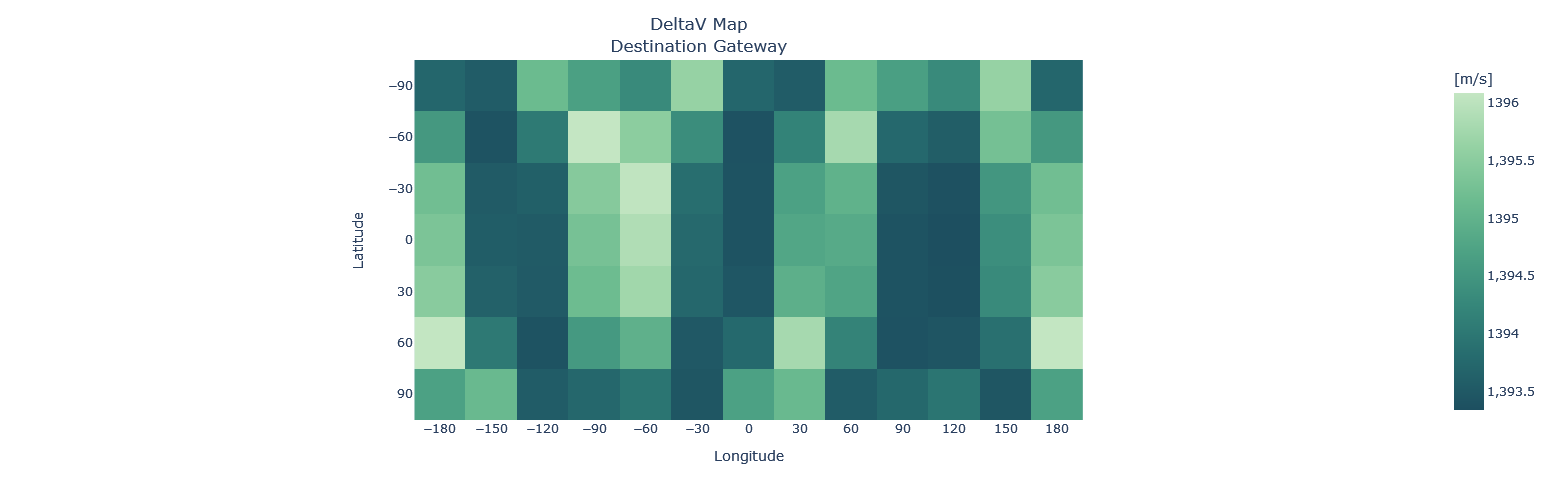

In [14]:
colorbar_title = xA_fuel_mass_Gateway.attrs['var_desc'] + '<br>(%s)'%xA_fuel_mass_Gateway.attrs['units']

#fig = px.imshow(results, color_continuous_scale='RdBu_r', aspect='equal')
fig = px.imshow(img=xA_fuel_mass_Gateway,
                width=1000,
                height=500,
                color_continuous_scale='blugrn_r',
                aspect='equal')

fig.update_xaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180])
fig.update_yaxes(tickangle=0,
                 tickmode = 'array',
                 tickvals = [-90,-60,-30,0,30,60,90])


fig.update_layout(
    xaxis_title='Longitude',
    yaxis_title='Latitude',
    title= 'DeltaV Map<br>Destination Gateway',
    title_x=0.45
)


#fig.write_image("fig/dv1.pdf")
fig.write_image("doc/img/dv_Gateway.pdf")
fig.show()


In [ ]:
#print(scenario.StartTime)
#print(scenario.StopTime)

In [ ]:
root.ExecuteCommand('SetState */Satellite/LeoSat Classical TwoBody "' +
                    str(scenario.StartTime) + '" "' + str(scenario.StopTime) +
                    '" 60 ICRF  "' + str(scenario.StartTime) + '" 7200000.0 0.0 90 0.0 0.0 0.0')

In [ ]:
access = satellite.GetAccessToObject(target)
access.ComputeAccess()

In [ ]:
accessDP         = access.DataProviders.Item('Access Data')

results          = accessDP.Exec(scenario.StartTime, scenario.StopTime)

accessStartTimes = results.DataSets.GetDataSetByName('Start Time').GetValues()

accessStopTimes  = results.DataSets.GetDataSetByName('Stop Time').GetValues()

print(accessStartTimes,accessStopTimes)

In [ ]:
accessIntervals = access.ComputedAccessIntervalTimes

dataProviderElements = ['Start Time', 'Stop Time']

for i in range(0,accessIntervals.Count):
    times = accessIntervals.GetInterval(i)
    print(times)

### Retrieve the Satellite Altitude Data From STK

Retrieve and view the altitude of the satellite during an access interval. In the following lines, note how the data providers must follow the data provider folder, sub-folder, and selection.

In [ ]:
satelliteDP       = satellite.DataProviders.Item('LLA State')

satelliteDP2      = satelliteDP.Group.Item('Fixed')

rptElements       = ['Time', 'Lat', 'Lon', 'Alt']

satelliteDPTimeVar = satelliteDP2.ExecElements(accessStartTimes,accessStopTimes, 60, rptElements)

satelliteAltitude = satelliteDPTimeVar.DataSets.GetDataSetByName('Alt').GetValues()

print(satelliteAltitude)

## Destination: Low Lunar Orbit (Equatorial)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Eq')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Low Lunar Orbit (Polar)
> open file "Gateway_PROP_Mass_Point.sc" in STK

In [ ]:
# Get reference to the current instance of STK
STK_PID = os.getenv('STK_PID')
stk = STKDesktop.AttachToApplication(pid=int(STK_PID))
root = stk.Root

# rewind to initial datetime
scenario = root.CurrentScenario
scenario.SetTimePeriod('01 Jan 2022 00:00:00.000','03 Jan 2022 00:00:00.000')
root.Rewind()

# load existing Satellite and Place
satellite = root.CurrentScenario.Children.Item('LLO_Sat_Pol')
place_start = root.CurrentScenario.Children.Item('Start')
place_start.Position.AssignGeodetic(0,0,0)

## Destination: Lagrange Point (L1) - Earth Moon System
> open file "Gateway_PROP_Mass_Point.sc" in STK

## Destination: Low Earth Orbit (Equatorial) - Starship refuel
> open file "Gateway_PROP_Mass_Point.sc" in STK